In [120]:
# import all relevant libraries
import pandas as pd
import numpy as np
import uuid
import re
import json
from pandas.plotting import register_matplotlib_converters
from pandas import json_normalize
import matplotlib.pyplot as plt

charging = pd.read_csv("modified_data.csv", encoding = "ISO-8859-1")

In [121]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])

<h1> Task 2 </h2>

<h2> Task 2 a.) - Showing daily demand

2 approaches for daily demand: 

1. show every single hour
2. divide day in morning, noon ect.

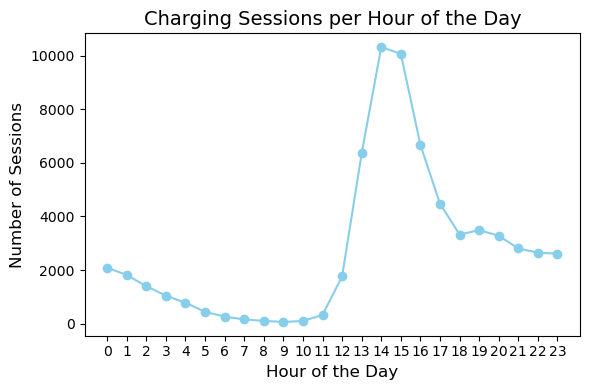

In [ ]:
#first approach

charging['hour_of_day'] = charging['connectionTime'].dt.hour

# Count the number of sessions for each hour of the day
sessions_per_hour = charging.groupby('hour_of_day').size()

plt.figure(figsize=(6, 4))
sessions_per_hour.plot(kind='line', color='skyblue', marker='o')

plt.xticks(range(0, 24))
plt.title('Charging Sessions per Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()

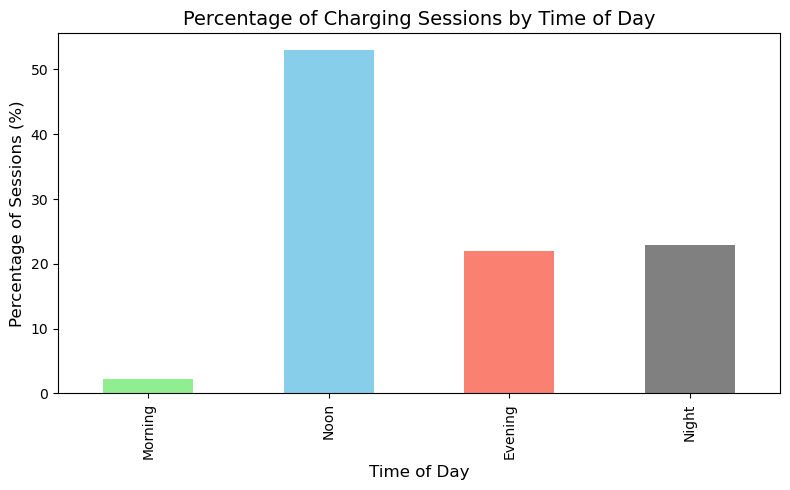

In [ ]:
def classify_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

charging['time_of_day'] = charging['connectionTime'].dt.hour.apply(classify_time_of_day)

# Number of charging sessions for each time of day
time_of_day_counts = charging['time_of_day'].value_counts().reindex(['Morning', 'Noon', 'Evening', 'Night'])

# Calculate percentage of each category
time_of_day_percentage = (time_of_day_counts / time_of_day_counts.sum()) * 100

# create bar chart
plt.figure(figsize=(8, 5))  
time_of_day_percentage.plot(kind='bar', color=['lightgreen', 'skyblue', 'salmon', 'gray'])

plt.title('Percentage of Charging Sessions by time of day', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Percentage of Sessions (%)', fontsize=12)
plt.tight_layout()
plt.show()


<h5>Interpretation</h5>

Regardless of the approach, we see that there is a **pattern in daily use**. In the early morning hours the demand is at its lowest and the demand increases as we reach Noon. The **peak time** of demand is the Noon time around 12pm to 6pm and in the evening from 6pm on the demand decreases linearly until the next day on 10am right before noon

In my opinion, the second approach (dividing day into 4 parts isntead of showing the demand hourly) is superior because we have longer intervals here and some processes might start at 10:59:59 and still are assigned to 10pm. With the divison based on intervals, we don't have these problems (or at least not as often)

<h2> Task 2 a.) - Showing weekly demand

The problem here is that 42% of the sessions start on one day and end in the next day or longer, so it isn't optimal to assign day belonging based on connection time

In [124]:
#count the percentage of sessions that go over multiple days
sessions_spanning_midnight = len(charging[charging['connectionTime'].dt.date != charging['disconnectTime'].dt.date])
percentage_spanning_midnight = (sessions_spanning_midnight / len(charging)) * 100

print(percentage_spanning_midnight)

42.27088036117381


<h4>Approach for showing weekly demand </h4>

The problem here is that some sessions might start at 23:59 and if we would only regard "connectionTime" for day belonging, some sessions which begin at 23:59 are assigned to this day which isn't accurate. 

My proposed soluton: for each row/session, compute the duration (disconnectTime-connectTime) and we assign the session to the day where the **majority of the charging duration** occured

Monday: 11095 sessions
Tuesday: 12826 sessions
Wednesday: 12661 sessions
Thursday: 12632 sessions
Friday: 10989 sessions
Saturday: 3600 sessions
Sunday: 2647 sessions


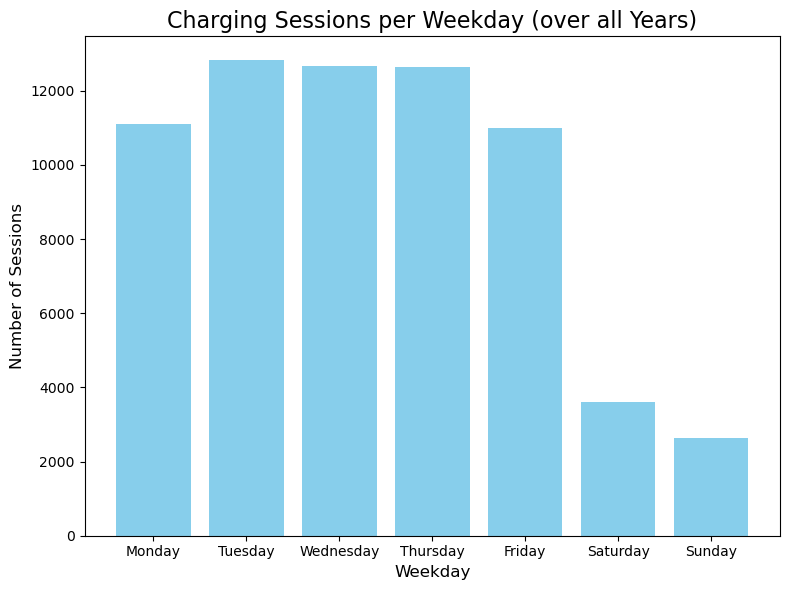

In [ ]:
weekday_counts = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}

for index, row in charging.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    
    # Calculate duration of particular session
    duration = disconnect_time - connection_time
    
    # Case 1: session is on the same day. if yes, we can stop here
    if connection_time.date() == disconnect_time.date():
        # Add to the weekday of the connection time
        weekday_counts[connection_time.strftime('%A')] += 1
    
    # Case 2: Session spanning multiple days
    else:
        # Split the duration into two parts:  
        # First part is from connetcion time to midnight of the same day
        # Second part is from midnight to disconnect time on the next day
        
        
        midnight_same_day = connection_time.replace(hour=23, minute=59, second=59)
        duration_first_day = midnight_same_day - connection_time
        
        midnight_on_next_day = disconnect_time.replace(hour=0, minute=0, second=0)
        duration_second_day = disconnect_time - midnight_on_next_day
        
        if duration_first_day > duration_second_day:
            weekday_counts[connection_time.strftime('%A')] += 1
        else:
            weekday_counts[disconnect_time.strftime('%A')] += 1


for day, count in weekday_counts.items():
    print(f"{day}: {count} sessions")


plt.figure(figsize=(8, 6))
plt.bar(weekday_counts.keys(), weekday_counts.values(), color='skyblue')
plt.title('Charging sessions per weekday (over all Years)', fontsize=16)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()


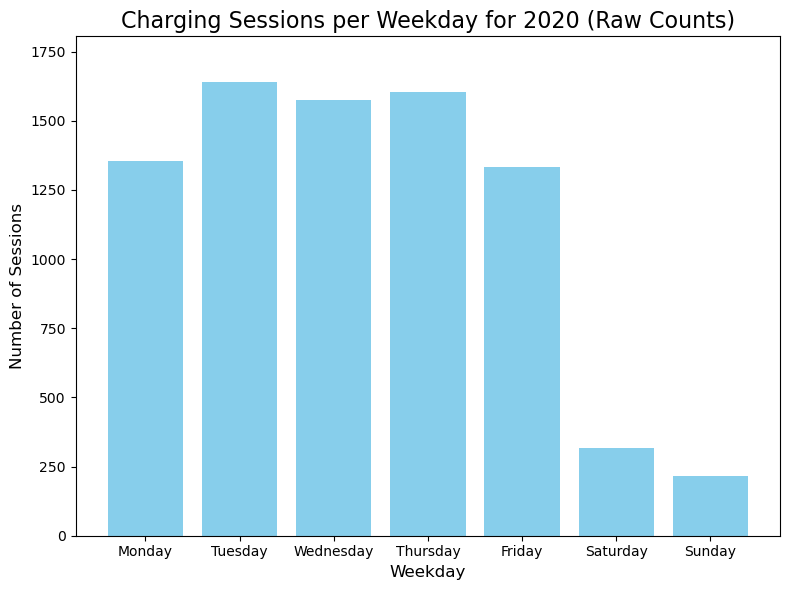

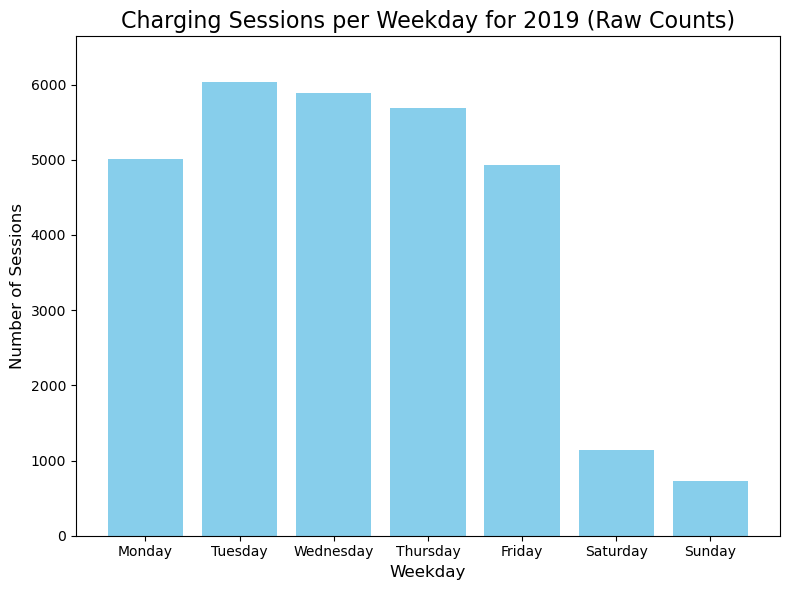

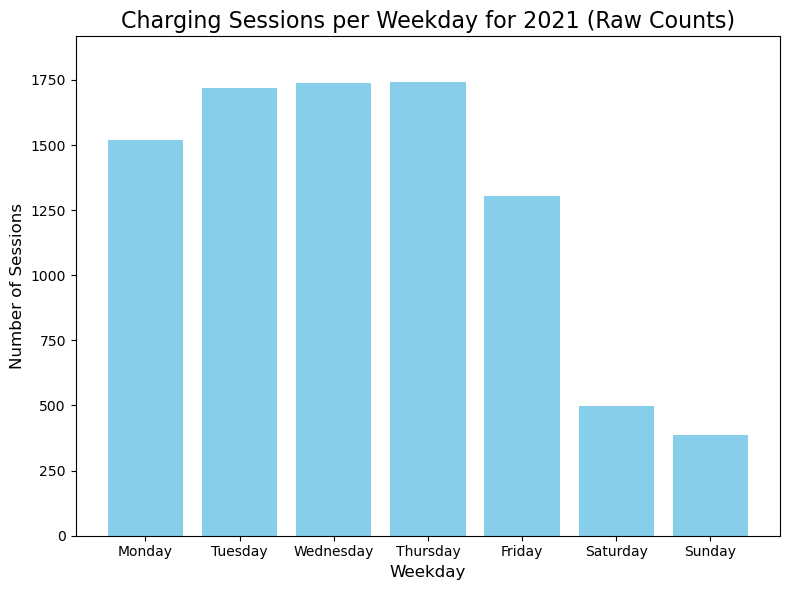

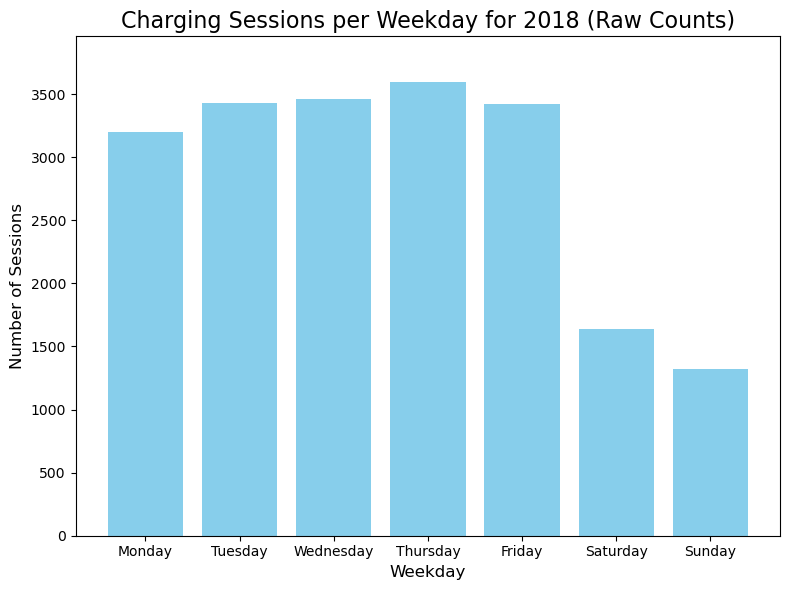

In [ ]:
#grouping the weeks by year (just for testing). here wo would have to normalize

yearly_weekday_counts = {}

for index, row in charging.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    
    duration = disconnect_time - connection_time
    
    year = connection_time.year
    
    if year not in yearly_weekday_counts:
        yearly_weekday_counts[year] = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}
    
    if connection_time.date() == disconnect_time.date():
        weekday = connection_time.strftime('%A')
        yearly_weekday_counts[year][weekday] += 1
    
    else:
        midnight_same_day = connection_time.replace(hour=23, minute=59, second=59)
        duration_first_day = midnight_same_day - connection_time
        midnight_on_next_day = disconnect_time.replace(hour=0, minute=0, second=0)
        duration_second_day = disconnect_time - midnight_on_next_day
        
        if duration_first_day > duration_second_day:
            weekday = connection_time.strftime('%A')
        else:
            weekday = disconnect_time.strftime('%A')
        
        yearly_weekday_counts[year][weekday] += 1

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for year, counts in yearly_weekday_counts.items():
    plt.figure(figsize=(8, 6))
    plt.bar(counts.keys(), counts.values(), color='skyblue')  # Use raw counts
    
    plt.title(f'Charging Sessions per Weekday for {year}', fontsize=16)
    plt.xlabel('Weekday', fontsize=12)
    plt.ylabel('Number of Sessions', fontsize=12)  
    plt.ylim(0, max(max(counts.values()) * 1.1, 25))  
    
    plt.tight_layout()
    plt.show()




Regardless of the which approach, we can clearly see that the peak days are tuesday, wednesday and thursday. On the weekend, demand isn't that hight. Intuitively, this makes sense as most people use their E-Cars in weekdays.

**Interestingly, the proportion of sessions in year 2018 on the weekend were higher than in the next years

<h2> Task 2 a.) - Showing season patterns

Proposed approaches: 
1. Divide year in sumer, spring, winter and autumn and show numbers (for each year)
2. Show the number of sessions over the years(i.e. for each year)


Try 1.

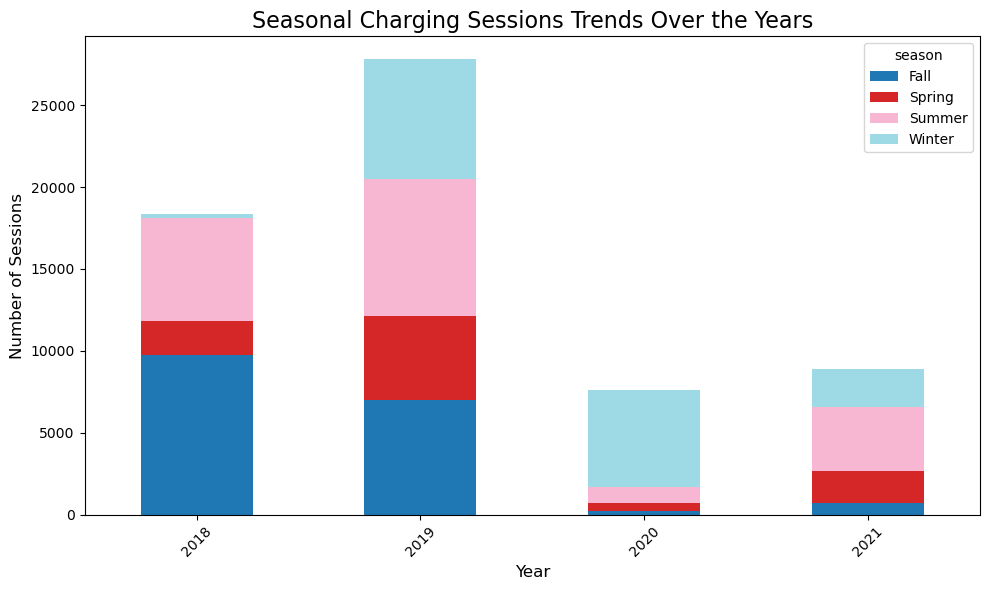

season  Fall  Spring  Summer  Winter
year                                
2018    9774    2026    6329     249
2019    6975    5166    8361    7304
2020     206     493     993    5894
2021     686    1979    3907    2338


In [ ]:
# Function to determine the season based on date
def get_season(date):
    if (date.month == 12 and date.day >= 21) or (date.month <= 3 and date.month >= 1):
        return 'Winter'
    elif 3 <= date.month <= 5:
        return 'Spring'
    elif 6 <= date.month <= 8:
        return 'Summer'
    elif 9 <= date.month <= 11:
        return 'Fall'

# Apply the function to the 'connectionTime' column
charging['season'] = charging['connectionTime'].apply(get_season)

# Extract the year from the connection time
charging['year'] = charging['connectionTime'].dt.year

# Group by year and season, then count the number of sessions
seasonal_trends = charging.groupby(['year', 'season']).size().unstack(fill_value=0)

# Plot the seasonal trends over the years
seasonal_trends.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title('Seasonal charging sessions trends over the years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

<h4>Interpretation</h4>

We see multiple things:

1. 2018 and 2019 had more sessions -> In year 2020 pandemic started and this could have resulted in a reduction commuting and traveling, reduction imports for material for these vehicles ect.

2. Fall had the most records in the years 2018 out of all records in year 2018